In [1]:
#!pip install numpy scipy noisyopt matplotlib qiskit==1.1.1 --no-cache-dir --force-reinstall --quiet

In [2]:
import numpy as np
import math as m
import pickle
import scipy as sp
import qiskit as qi
from qiskit.circuit import library as li
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.primitives import Estimator, Sampler


est = Estimator()
sampler = Sampler()


nx = 4
ny = 4
nqb = nx + ny
lay = 5
shots = None

L = 1.0
Nx = 2 ** nx
Ny = 2 ** ny
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
dx = L / (Nx-1.)
dy = L / (Ny-1.)

def get_K(Nx, Ny, dx, dy, alpha):
    N = Nx * Ny
    K = sp.sparse.lil_matrix((N, N))
    for i in range(Nx):
        for j in range(Ny):
            idx = i * Ny + j
            if i < Nx-1:
                right = idx + Ny
                K[idx, idx] += alpha / dx**2
                K[idx, right] -= alpha / dx**2
                K[right, idx] -= alpha / dx**2
                K[right, right] += alpha / dx**2
            if j < Ny-1:
                top = idx + 1
                K[idx, idx] += alpha / dy**2
                K[idx, top] -= alpha / dy**2
                K[top, idx] -= alpha / dy**2
                K[top, top] += alpha / dy**2
    return K

def flux(nx, ny, prc, flux_bc):
    nqb = nx + ny
    f = np.zeros(2 ** nqb)
    Nx = 2 ** nx
    Ny = 2 ** ny
    miny = round((1-prc) * Ny)
    for i in range(miny, Ny):
        f[(Nx - 1) * Ny + i] = flux_bc
    norm = np.linalg.norm(f)
    if norm != 0:
        f /= norm
    return f

alpha = 1.0
Ksp = get_K(Nx, Ny, dx, dy, alpha)
pen = 0.1*9/16
Ksp += pen * np.eye(Nx*Ny)
K = Ksp.toarray()
therm_bc = 0
flux_bc = 3/np.sqrt(2)/16/dx
prc = 0.5
f = flux(nx, ny, prc, flux_bc)


una_ans = li.RealAmplitudes(num_qubits=nqb, entanglement='sca', reps=lay)
num_par = una_ans.num_parameters

def get_psi(una_ans, par):

    ans = una_ans.assign_parameters(parameters=par, inplace=False)
    cir = qi.QuantumCircuit(nqb)
    cir.append(ans, list(range(nqb)))
    cir.measure_all()
    job = sampler.run([cir], shots=shots)
    probas = job.result().quasi_dists[0]
    psi = np.zeros(2 ** nqb)
    for i in range(2 ** nqb):
        psi[i] = np.sqrt(probas[i]) if i in probas else 0
    psi /= np.linalg.norm(psi)
    return psi

# Classical solution (target vector for overlap)
ucl = sp.sparse.linalg.spsolve(Ksp.tocsr(), f).real
ucl /= np.linalg.norm(ucl)

# Cost function: maximize overlap with classical solution
def overlap_cost(par, una_ans, ucl):
    psi = get_psi(una_ans, par)
    ov = np.abs(np.dot(ucl, psi))
    return -ov  # maximize overlap

# Optimize parameters to maximize overlap
print("Fitting ansatz state to classical solution for warm start...")
np.random.seed(42)  # For reproducibility
par_init = np.random.uniform(-2*np.pi, 2*np.pi, num_par)
res_fit = sp.optimize.minimize(
    lambda par: overlap_cost(par, una_ans, ucl),
    par_init,
    method='L-BFGS-B',
    bounds=[(-2*np.pi, 2*np.pi)] * num_par,
    options={'maxiter': 300}
)
par_warm = res_fit.x
pickle.dump(par_warm, open("warm_start_8qubits.pkl", "wb"))
print("Warm start saved to 'warm_start_8qubits.pkl'.")
print("Best overlap achieved:", -res_fit.fun)


Fitting ansatz state to classical solution for warm start...
Warm start saved to 'warm_start_8qubits.pkl'.
Best overlap achieved: 0.9044057285183259


Loaded warm start.
Layers : 5
Number of parameters:  48
Number of DOFs:  256
   *** Beginning VQA optimization ***   
Iteration : 1, Current cost: 660.857200
Iteration : 2, Current cost: 542.832052
Iteration : 3, Current cost: 421.899198
Iteration : 4, Current cost: 323.722951
Iteration : 5, Current cost: 240.503043
Iteration : 6, Current cost: 187.119443
Iteration : 7, Current cost: 142.921639
Iteration : 8, Current cost: 93.955741
Iteration : 9, Current cost: 77.431223
Iteration : 10, Current cost: 62.920931
Iteration : 11, Current cost: 58.006625
Iteration : 12, Current cost: 50.077986
Iteration : 13, Current cost: 45.990351
Iteration : 14, Current cost: 42.542959
Iteration : 15, Current cost: 39.821518
Iteration : 16, Current cost: 35.090297
Iteration : 17, Current cost: 29.863943
Iteration : 18, Current cost: 23.089529
Iteration : 19, Current cost: 18.493327
Iteration : 20, Current cost: 14.674029
Iteration : 21, Current cost: 11.717278
Iteration : 22, Current cost: 8.311420
Itera

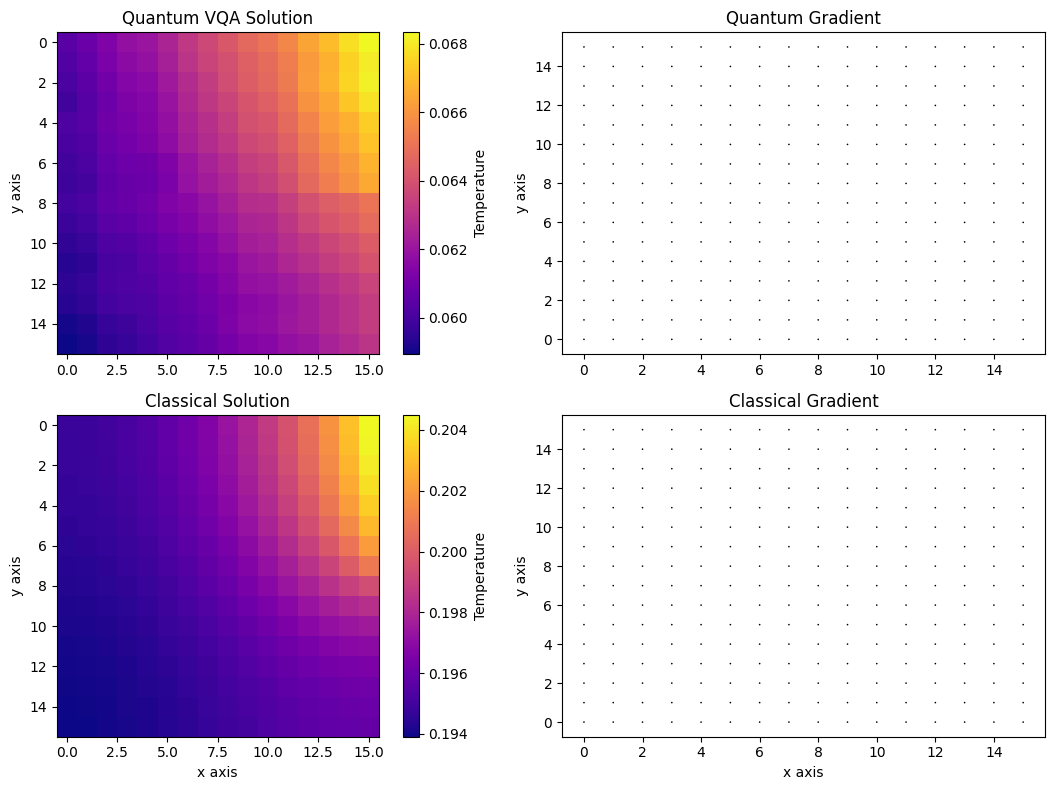

In [3]:
import numpy as np
import math as m
import time
import pickle
import scipy as sp
import qiskit as qi  # 1.1.1
from qiskit.circuit import library as li
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.primitives import Estimator, Sampler
import matplotlib.pyplot as plt


est = Estimator()
sampler = Sampler()

def get_K(Nx, Ny, dx, dy, alpha):
    N = Nx * Ny
    K = sp.sparse.lil_matrix((N, N))
    for i in range(Nx):
        for j in range(Ny):
            idx = i * Ny + j
            if i < Nx-1:
                right = idx + Ny
                K[idx, idx] += alpha / dx**2
                K[idx, right] -= alpha / dx**2
                K[right, idx] -= alpha / dx**2
                K[right, right] += alpha / dx**2
            if j < Ny-1:
                top = idx + 1
                K[idx, idx] += alpha / dy**2
                K[idx, top] -= alpha / dy**2
                K[top, idx] -= alpha / dy**2
                K[top, top] += alpha / dy**2
    return K

def flux(nx, ny, prc, flux_bc):
    nqb = nx + ny
    f = np.zeros(2 ** nqb)
    Nx = 2 ** nx
    Ny = 2 ** ny
    miny = round((1-prc) * Ny)
    for i in range(miny, Ny):
        f[(Nx - 1) * Ny + i] = flux_bc
    f /= np.linalg.norm(f)
    return f

def get_psi(una_ans, par):
    ans = una_ans.assign_parameters(parameters=par, inplace=False)
    cir = qi.QuantumCircuit(nqb)
    cir.append(ans, list(range(nqb)))
    cir.measure_all()
    job = sampler.run([cir], shots=shots)
    probas = job.result().quasi_dists[0]
    psi = np.zeros(2 ** nqb)
    for i in range(2 ** nqb):
        psi[i] = np.sqrt(probas[i]) if i in probas else 0
    psi /= np.linalg.norm(psi)
    return psi

def vqa_cost(par, SPOH, f, una_ans):
    # <psi|K|psi>
    obs = SPOH
    job = est.run([una_ans], [obs], [par], shots=shots)
    expect = job.result().values[0]
    # <f|psi>
    psi = get_psi(una_ans, par)
    fpsi = np.dot(f, psi)
    return expect - 2 * np.real(fpsi)

def build_callback(SPOH, f, callback_dict, una_ans):
    def callback(current_vector):
        callback_dict["iters"] += 1
        callback_dict["prev_vector"] = current_vector
        current_cost = vqa_cost(current_vector.real, SPOH, f, una_ans)
        callback_dict["cost_history"].append(current_cost)
        print(f"Iteration : {callback_dict['iters']}, Current cost: {current_cost:.6f}")
    return callback

nx = 4
ny = 4
nqb = nx + ny
lay = 5
shots = None

L = 1.0
Nx = 2 ** nx
Ny = 2 ** ny
x = np.linspace(0, L, Nx)
y = np.linspace(0, L, Ny)
dx = L / (Nx-1.)
dy = L / (Ny-1.)

alpha = 1.0
Ksp = get_K(Nx, Ny, dx, dy, alpha)
pen = 0.1*9/16
Ksp += pen * np.eye(Nx*Ny)
K = Ksp.toarray()
SPOH = SparsePauliOp.from_operator(Operator(K))

therm_bc = 0
flux_bc = 3/np.sqrt(2)/16/dx
prc = 0.5
f = flux(nx, ny, prc, flux_bc)

una_ans = li.RealAmplitudes(num_qubits=nqb, entanglement='sca', reps=lay)
num_par = una_ans.num_parameters

BC = [[-2*np.pi, 2*np.pi] for _ in range(num_par)]

# Load warm start
with open("warm_start_8qubits.pkl", "rb") as f_pickle:
    par_warm = pickle.load(f_pickle)
print("Loaded warm start.")

callback_dict = {"prev_vector": None, "iters": 0, "cost_history": []}
callback = build_callback(SPOH, f, callback_dict, una_ans)

# VQA Optimization
optim = True
if optim:
    print("Layers :", lay)
    print("Number of parameters: ", num_par)
    print("Number of DOFs: ", 2**nqb)
    print("   *** Beginning VQA optimization ***   ")
    start = time.perf_counter()
    res = sp.optimize.minimize(
        vqa_cost,
        par_warm,
        args=(SPOH, f, una_ans),
        tol=1e-7,
        method='L-BFGS-B',
        callback=callback,
        bounds=BC
    )
    end = time.perf_counter()
    exe_time = end - start

    print("Message :", res.message)
    print("Success :", res.success)
    print("nfev :", res.nfev)
    print("x :", res.x)
    print(f"Optimization time: {exe_time//60:.0f}m {exe_time%60:.2f}s")
    print("Quantum minimum (VQA cost):", res.fun)

    res = res.x
else:
    pass

def get_Xq(res_x, una_ans):
    ans_sol = una_ans.assign_parameters(parameters=res_x, inplace=False)
    cir_sol = qi.QuantumCircuit(nqb)
    cir_sol.append(ans_sol, list(range(nqb)))
    cir_sol.measure_all()
    job_sol = sampler.run([cir_sol])
    res_sol = job_sol.result()
    res_sol = res_sol.quasi_dists
    Xquant = np.zeros(2 ** nqb)
    for i in range(2 ** nqb):
        Xquant[i] = np.sqrt(res_sol[0][i]) if i in res_sol[0] else 0
    Xquant /= np.linalg.norm(Xquant)
    return Xquant

xquant = get_Xq(res, una_ans)
ucl = sp.sparse.linalg.spsolve(Ksp.tocsr(), f).real

normq = np.linalg.norm(xquant)
normc = np.linalg.norm(ucl)
print("Norme quantum Xquant :", normq)
print("Norme classique Ucl :", normc)

def MSE(u, v):
    return sum((u - v) ** 2) / len(u)
mse = MSE(xquant, ucl)
print(f"MSE error : {mse:.6f}")

u = xquant.reshape((Nx, Ny)).T
ucl = ucl.reshape((Nx, Ny)).T[::-1]
vmin = min(u.min(), ucl.min())
vmax = max(u.max(), ucl.max())

fig, ax = plt.subplots(2, 2, figsize=(11, 8))
iso = False

if iso:
    cax_heat = ax[0][0].contourf(x, y, u[::, ::], levels=20, cmap='plasma')
else:
    cax_heat = ax[0][0].imshow(u[::-1, ::], cmap='plasma', interpolation='nearest')
ax[0][0].set_title('Quantum VQA Solution')
ax[0][0].set_ylabel("y axis")
fig.colorbar(cax_heat, ax=ax[0][0], label='Temperature')

grad_x, grad_y = np.gradient(np.multiply(u[::, ::], -1))
ax[0][1].quiver(grad_y, grad_x, scale=1)
ax[0][1].set_title('Quantum Gradient')
ax[0][1].set_ylabel("y axis")

if iso:
    cax_heat = ax[1][0].contourf(x, y, ucl[::-1, ::], levels=20, cmap='plasma')
else:
    cax_heat = ax[1][0].imshow(ucl[::, ::], cmap='plasma', interpolation='nearest')
ax[1][0].set_title('Classical Solution')
ax[1][0].set_xlabel("x axis")
ax[1][0].set_ylabel("y axis")
fig.colorbar(cax_heat, ax=ax[1][0], label='Temperature')

grad_x, grad_y = np.gradient(np.multiply(ucl[::-1], -1))
ax[1][1].quiver(grad_y, grad_x, scale=1)
ax[1][1].set_title('Classical Gradient')
ax[1][1].set_xlabel("x axis")
ax[1][1].set_ylabel("y axis")

plt.tight_layout()
plt.show()

